In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [44]:
data = pd.read_csv("../2_lab_csv/lab2/normalized_full_NO_missing.csv", sep =',')

In [45]:

seed = 6521
df = (
    data[data["label"].notna()]
    .groupby("label", group_keys=False)
    .apply(lambda x: x.sample(n=500, replace=False, random_state=seed))
) # atsitiktinai isrenkame po 500 irasu kiekvienai klasei



C:\Users\Liveta\AppData\Local\Temp\ipykernel_19972\1109826219.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=500, replace=False, random_state=seed))


In [37]:
df = data

In [46]:
def outliers_function(data, column, factor):
    col = pd.to_numeric(data[column]).astype(float)

    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    lower_15 = Q1 - 1.5 * IQR
    upper_15 = Q3 + 1.5 * IQR
    lower_3 = Q1 - 3 * IQR
    upper_3 = Q3 + 3 * IQR

    if factor == 3:  # ekstremalios isskirtys
        out = col[(col < lower_3) | (col > upper_3)]
    elif factor == 1.5:  # salygines isskirtys
        out = col[((col < lower_15) & (col >= lower_3)) |
                  ((col > upper_15) & (col <= upper_3))]
    else:
        out = pd.Series(dtype=float)
    return out.index


feature_columns = [c for c in df.columns if c != 'label']

conditional_outliers = set()
extreme_outliers = set()

for col in feature_columns:
    cond_idx = outliers_function(df, col, 1.5)
    extr_idx = outliers_function(df, col, 3)
    conditional_outliers.update(cond_idx)
    extreme_outliers.update(extr_idx)


df['outlier'] = df['label']

# salygines
df.loc[df.index.isin(conditional_outliers), 'outlier'] = 3

# ekstremalios
df.loc[df.index.isin(extreme_outliers), 'outlier'] = 4


X = df.drop(columns=['label', 'outlier']).values
y_class = df['label'].values
y_group = df['outlier'].values

Skaičiuojama MDS (SMACOF)...


C:\Users\Liveta\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_mds.py:362: FutureWarning: The default value of `n_init` will change from 8 to 1 in 1.9.
  warnings.warn(


STRESS reikšmė: 481313.59942
Kruskal stress: 0.21640


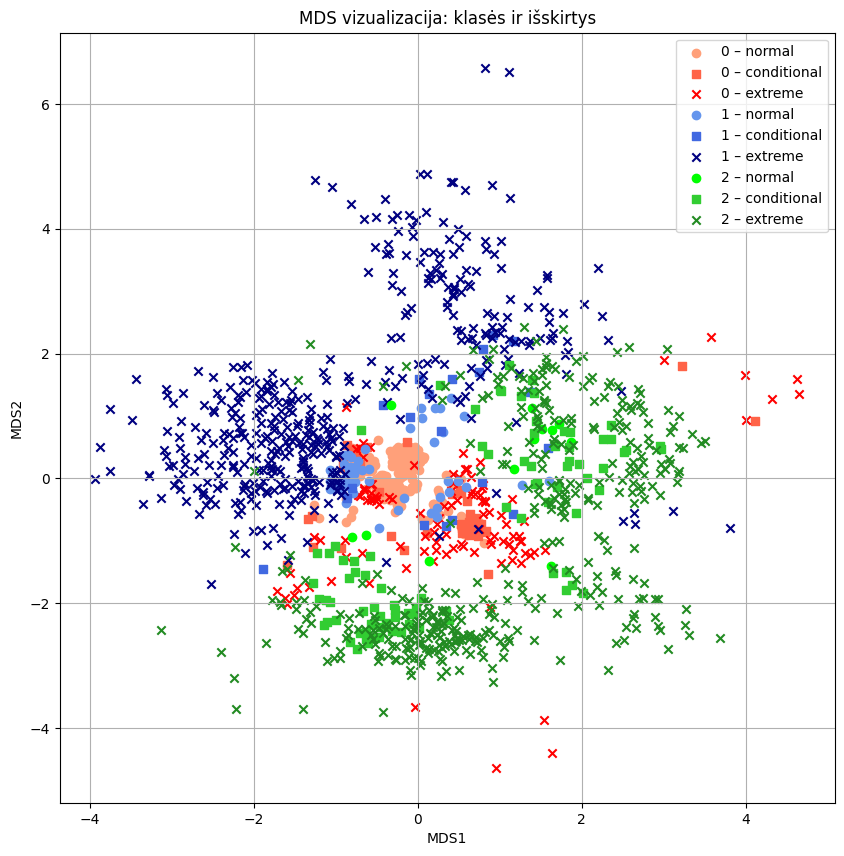

In [47]:
from sklearn.manifold import smacof

all_metrics = [
    # "euclidean",
    # "cosine",
    "manhattan",
]

for m in all_metrics:

    # Skaičiuojame porinius atstumus
    D = pairwise_distances(X, metric=m)


    print("Skaičiuojama MDS (SMACOF)...")
    data_2d, stress = smacof(D, n_components=2, max_iter=300, eps=1e-6, random_state=42)
    print(f"STRESS reikšmė: {stress:.5f}")
    mds_dist = pairwise_distances(data_2d)
    stress1 = np.sqrt(((D - mds_dist) ** 2).sum() / (D ** 2).sum())
    print(f"Kruskal stress: {stress1:.5f}")

    color_map = {
        (0, 'normal'): 'lightsalmon',
        (0, 'conditional'): 'tomato',
        (0, 'extreme'): 'red',

        (1, 'normal'): 'cornflowerblue',
        (1, 'conditional'): 'royalblue',
        (1, 'extreme'): 'navy',

        (2, 'normal'): 'lime',
        (2, 'conditional'): 'limegreen',
        (2, 'extreme'): 'forestgreen'
    }


    markers = {'normal': 'o', 'conditional': 's', 'extreme': 'x'}

    plt.figure(figsize=(10, 10))

    for i in range(3):  # klasės
        for group_name, group_value in zip(['normal', 'conditional', 'extreme'], [i, 3, 4]):
            mask = (y_class == i) & (y_group == group_value)
            if np.any(mask):
                plt.scatter(
                    data_2d[mask, 0],
                    data_2d[mask, 1],
                    color=color_map[(i, group_name)],
                    marker=markers[group_name],
                    label=f"{i} – {group_name}"
                )
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=10)

    plt.title("MDS vizualizacija: klasės ir išskirtys")
    plt.xlabel("MDS1")
    plt.ylabel("MDS2")
    plt.grid(True)
    plt.show()
